In [1]:
import datetime
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import statsmodels.stats.api as sms
import pandas as pd
from dateutil.tz import tzutc

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

Boilerplate Connection Setup
---

In [3]:
%load_ext edx_jupyter

In [4]:
%reload_ext edx_jupyter

In [6]:
%vertica SELECT 'Connected'

,?column?
0,Connected


In [7]:
alpha = 0.1
effect_size = 0.2
power = 0.8
experiment_id = 8416329705

In [8]:
# When pulling numbers, use this as the end-time
transaction_cutoff = datetime.datetime(2017, 6, 21, 0, tzinfo=tzutc())

# Note this just needs to be anytime *before* the start of the experiment, it is simply used to limit the amount of
# data fetched by some queries
experiment_start = datetime.datetime(2017, 6, 13, 0, tzinfo=tzutc())

Set the time zone for the vertica session to UTC. This is needed to correctly coerce string columns into TIMESTAMPTZ.

In [9]:
%%vertica

SET TIME ZONE 'UTC'

,?column?


Segment's "anonymous_id" is expected to more closely match Optimizely's end user ID than edX's internal user ID. This is because edX's ID will be stable across devices, but neither Segment's ID nor Optimizely's will. This workbook assumes anonymous_id is roughly the same as an Optimizely "visitor".

In [10]:
%%vertica (start_time = experiment_start, end_time = transaction_cutoff, experiment_id = experiment_id) -> warehouse_reach
SELECT
    variationname AS name,
    COUNT(DISTINCT anonymous_id) AS segment_visitor_count
FROM
    experimental_events_run14.event_records event
WHERE
        event_type = 'Experiment Viewed'
    AND experimentid = :experiment_id
    AND received_at::TIMESTAMPTZ < :end_time
GROUP BY 1

In [11]:
warehouse_reach

,name,segment_visitor_count
0,Fixed Footer,66372
1,Hero,65973
2,Original,66213


Now pull the same data from optimizely.

In [12]:
import edx_secret
api_token = edx_secret.read_secret_from_env_or_prompt('OPS_OPTIMIZELY_TOKEN')

In [13]:
import requests
res = requests.get('https://api.optimizely.com/v2/experiments/{0}/results?end_time={1}'.format(experiment_id, transaction_cutoff.isoformat().split('+')[0] + 'Z'), headers={'Authorization': 'Bearer {}'.format(api_token)})
experiment_results = res.json()

In [14]:
optimizely_reach = pd.DataFrame(experiment_results['reach']['variations']) \
    .transpose() \
    .rename(columns={'count': 'optimizely_visitor_count'})

Compare the optimizely data and the segment data.

In [15]:
compare_reach = optimizely_reach.merge(warehouse_reach, on='name')
compare_reach['diff'] = compare_reach['segment_visitor_count'] - compare_reach['optimizely_visitor_count']
compare_reach['percent_diff'] = (compare_reach['diff'] / compare_reach['optimizely_visitor_count'].astype(float)) * 100.0
compare_reach[['name', 'segment_visitor_count', 'optimizely_visitor_count', 'diff', 'percent_diff']]

,name,segment_visitor_count,optimizely_visitor_count,diff,percent_diff
0,Fixed Footer,66372,65858,514,0.780467
1,Original,66213,65832,381,0.578746
2,Hero,65973,65306,667,1.02135


We see roughly 1% more visitors in our segment analysis than we see in optimizely.

In [16]:
%%vertica (start_time = experiment_start, end_time = transaction_cutoff, experiment_id = experiment_id) -> conversions_raw

SELECT
    viewed.variation_name,
    viewed.anonymous_id,
    CASE WHEN SUM(purchased.bookings) > 0 THEN 1 ELSE 0 END AS converted,
    SUM(purchased.bookings) AS bookings
FROM
(
    SELECT DISTINCT
        anonymous_id,
        FIRST_VALUE(variationname) OVER (PARTITION BY anonymous_id ORDER BY received_at ASC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS variation_name,
        FIRST_VALUE(received_at) OVER (PARTITION BY anonymous_id ORDER BY received_at ASC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)::TIMESTAMPTZ AS exposure_time
    FROM
        experimental_events_run14.event_records event
    WHERE
            event_type = 'Experiment Viewed'
        AND experimentid = :experiment_id
        AND received_at::TIMESTAMPTZ < :end_time
) AS viewed
LEFT JOIN
(
    SELECT
        event.anonymous_id,
        REGEXP_SUBSTR(event.search, 'EDX-\d+') AS order_id,
        o.total_incl_tax AS bookings,
        MIN(event.received_at::TIMESTAMPTZ) AS purchase_time
    FROM
        experimental_events_run14.event_records event
    LEFT JOIN
        otto_read_replica.order_order o ON o.number = REGEXP_SUBSTR(event.search, 'EDX-\d+')
    WHERE
            event.event_type = 'page'
        AND event.project = 'GHEUdjuJS4'
        AND event.path='/checkout/receipt/'
        AND event.received_at::TIMESTAMPTZ > :start_time
    GROUP BY 1, 2, 3
) AS purchased 
    ON  viewed.anonymous_id = purchased.anonymous_id
    AND purchased.purchase_time > viewed.exposure_time
    AND purchased.purchase_time < :end_time
GROUP BY 1, 2

In [17]:
conversions = conversions_raw.set_index('variation_name')

In [18]:
warehouse_converted = conversions.groupby(level=0).sum()[['converted']].rename(columns={'converted': 'segment_converted'})

In [19]:
warehouse_converted

,segment_converted
variation_name,
Fixed Footer,879
Hero,801
Original,725


In [20]:
compare_conversions = pd.DataFrame(experiment_results['metrics'][0]['results']) \
    .transpose() \
    .rename(columns={'value': 'optimizely_converted'}) \
    .merge(warehouse_converted, left_on='name', right_index=True)
compare_conversions['diff'] = compare_conversions['segment_converted'] - compare_conversions['optimizely_converted']
compare_conversions['percent_diff'] = compare_conversions['diff'] / compare_conversions['optimizely_converted'] * 100
compare_conversions[['name', 'segment_converted', 'optimizely_converted', 'diff', 'percent_diff']]

,name,segment_converted,optimizely_converted,diff,percent_diff
8411657731,Fixed Footer,879,910,-31,-3.40659
8415657676,Original,725,770,-45,-5.84416
8421800642,Hero,801,833,-32,-3.84154


In [21]:
def plot_confidence_interval(res, axes):
    bar_height = 0.25
    axes.axvline(x=0)
    face_color = '0.75'
    if res.lower_bound > 0:
        face_color = 'lightgreen'
    elif res.upper_bound < 0:
        face_color = 'lightred'
    axes.add_patch(
        patches.Rectangle(
            (res.lower_bound, -(bar_height / 2)),
            res.upper_bound - res.lower_bound,
            bar_height,
            facecolor=face_color
        )
    )
    axes.add_line(Line2D([res.value, res.value], [-(bar_height / 2), (bar_height / 2)], color='k'))
    axes.text(res.lower_bound, (bar_height/2)*1.1, str(round(res.lower_bound, 2)) + '%')
    axes.text(res.value, -(bar_height/2)*2, str(round(res.value, 2)) + '%')
    axes.text(res.upper_bound, (bar_height/2)*1.1, str(round(res.upper_bound, 2)) + '%')

In [22]:
def plot_comparative_intervals(intervals, titles):
    num_intervals = len(intervals)
    f, axarr = plt.subplots(num_intervals, sharex=True)

    max_x = 0
    for interval in intervals:
        if abs(interval.lower_bound) > max_x:
            max_x = abs(interval.lower_bound)
        if abs(interval.upper_bound) > max_x:
            max_x = abs(interval.upper_bound)
    
    for index, interval in enumerate(intervals):
        axarr[index].set_xlim([-(max_x*1.3), max_x*1.3])
        axarr[index].set_ylim([-1, 1])
        axarr[index].set_title(titles[index])
        plot_confidence_interval(interval, axarr[index])

In [23]:
def test_significance(control_data, test_data):
    bs_res = bs.bootstrap_ab(
        test_data,
        control_data,
        stat_func=bs_stats.mean,
        compare_func=bs_compare.percent_change,
        num_iterations=10000,
        num_threads=-1,
        alpha=alpha
    )
    return bs_res

In [24]:
def summarize_conversion_rate(label, data):
    relative_change = bs_compare.percent_change(data.mean(), ctrl.mean())
    print('{0} {1}/{2} CR={3}% Change={4}{5}%'.format(
        label,
        round(data.sum(), 2),
        len(data),
        round(data.mean() * 100, 2),
        '+' if relative_change >= 0 else '',
        round(relative_change, 2)
    ))

--- Summary of groups ---
Original 725/66086 CR=1.1% Change=+0.0%
Hero 801/65840 CR=1.22% Change=+10.9%
Fixed Footer 879/66251 CR=1.33% Change=+20.94%

--- Necessary sample size per group ---
At least 30557 users per group

--- Fixed Footer ---
20.939424206479135    (10.441560384212707, 30.560700404887427)

--- Hero ---
10.895558721246923    (1.2021730896448553, 19.933465624466443)



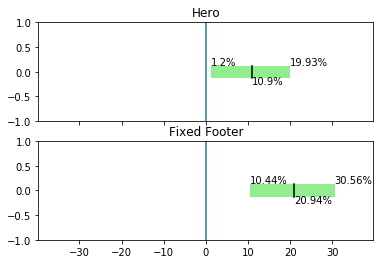

In [25]:
ctrl = np.array(conversions.loc['Original'].converted)
test_hero = np.array(conversions.loc['Hero'].converted)
test_fixed_footer = np.array(conversions.loc['Fixed Footer'].converted)

print('--- Summary of groups ---')
summarize_conversion_rate('Original', ctrl)
summarize_conversion_rate('Hero', test_hero)
summarize_conversion_rate('Fixed Footer', test_fixed_footer)
print()

print('--- Necessary sample size per group ---')
es = sms.proportion_effectsize(ctrl.mean(), ctrl.mean()*(1 + effect_size))
sample_size = round(sms.NormalIndPower().solve_power(es, power=power, alpha=alpha, ratio=1))
print('At least {0} users per group'.format(sample_size))
print()

print('--- Fixed Footer ---')
fixed_footer_ci = test_significance(ctrl, test_fixed_footer)
print(fixed_footer_ci)
print()

print('--- Hero ---')
hero_ci = test_significance(ctrl, test_hero)
print(hero_ci)
print()

plot_comparative_intervals([hero_ci, fixed_footer_ci], ['Hero', 'Fixed Footer'])

In [26]:
def summarize_bookings(label, data):
    relative_change = bs_compare.percent_change(data.mean(), ctrl.mean())
    print('{0} ${1}/{2} $/visitor=${3} Change={4}{5}%'.format(
        label,
        round(data.sum(), 2),
        len(data),
        round(data.mean(), 2),
        '+' if relative_change >= 0 else '',
        round(relative_change, 2)
    ))

--- Summary of groups ---
Original $65957.7/66086 $/visitor=$1.0 Change=+0.0%
Hero $74462.4/65840 $/visitor=$1.13 Change=+13.32%
Fixed Footer $81594.1/66251 $/visitor=$1.23 Change=+23.4%

--- Fixed Footer ---
23.398613919250938    (8.242436192017195, 36.47863066958844)

--- Hero ---
13.315983025617141    (-0.3835307641474621, 25.33688015259426)



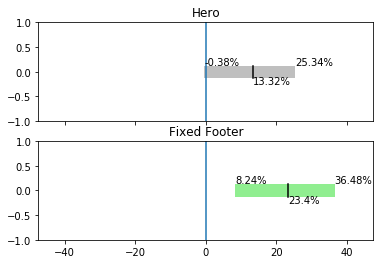

In [27]:
ctrl = np.array(conversions.loc['Original'].bookings.fillna(0).astype(float))
test_hero = np.array(conversions.loc['Hero'].bookings.fillna(0).astype(float))
test_fixed_footer = np.array(conversions.loc['Fixed Footer'].bookings.fillna(0).astype(float))

print('--- Summary of groups ---')
summarize_bookings('Original', ctrl)
summarize_bookings('Hero', test_hero)
summarize_bookings('Fixed Footer', test_fixed_footer)
print()

print('--- Fixed Footer ---')
fixed_footer_ci = test_significance(ctrl, test_fixed_footer)
print(fixed_footer_ci)
print()

print('--- Hero ---')
hero_ci = test_significance(ctrl, test_hero)
print(hero_ci)
print()

plot_comparative_intervals([hero_ci, fixed_footer_ci], ['Hero', 'Fixed Footer'])

In [28]:
%%vertica (start_time = experiment_start, end_time = transaction_cutoff, experiment_id = experiment_id) -> order_completions

SELECT
    viewed.variation_name,
    viewed.anonymous_id,
    CASE WHEN COUNT(purchased.anonymous_id) > 0 THEN 1 ELSE 0 END AS converted
FROM
(
    SELECT DISTINCT
        anonymous_id,
        FIRST_VALUE(variationname) OVER (PARTITION BY anonymous_id ORDER BY received_at ASC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS variation_name,
        FIRST_VALUE(received_at) OVER (PARTITION BY anonymous_id ORDER BY received_at ASC ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)::TIMESTAMPTZ AS exposure_time
    FROM
        experimental_events_run14.event_records event
    WHERE
            event_type = 'Experiment Viewed'
        AND experimentid = :experiment_id
        AND received_at::TIMESTAMPTZ < :end_time
) AS viewed
LEFT JOIN
(
    SELECT
        event.anonymous_id,
        MIN(event.received_at::TIMESTAMPTZ) AS purchase_time
    FROM
        experimental_events_run14.event_records event
    WHERE
            event.event_type = 'Order Completed'
        AND event.event_source = 'client'
        AND event.received_at::TIMESTAMPTZ > :start_time
    GROUP BY 1
) AS purchased 
    ON  viewed.anonymous_id = purchased.anonymous_id
    AND purchased.purchase_time > viewed.exposure_time
    AND purchased.purchase_time < :end_time
GROUP BY 1, 2

In [29]:
order_completions.groupby('variation_name').sum().converted

variation_name
Fixed Footer    1007
Hero             913
Original         868
Name: converted, dtype: int64

In [30]:
total = order_completions.groupby('variation_name').sum().converted.sum()
total

2788

In [31]:
opt_total = 910+770+833
opt_total

2513